# Which pixels of the input are the most salient for the classification task?
### Model Interpretability via feature attribution 


In [12]:
import sys
sys.path.append("..")
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data.car_dataset import CarDataset, data_transforms, inverse_transform, year2label_fn
from data.data_splitting import split_dataset_dfs

from analysis import plotting

In [2]:
# load dataframes

features_df = pd.read_csv("../../raw_data/tables/features.csv")


train_df, val_df, test_df = split_dataset_dfs("../../raw_data/tables/features.csv")




In [3]:
min_year = features_df["Launch_Year"].min() # oldest car launch_year in data
max_year = features_df["Launch_Year"].max()
year_bucket_size = 2

In [4]:
# create dataset
train_set = CarDataset(features=train_df, transform=data_transforms["train"],year2label_fn=lambda year:year2label_fn(year, min_year = min_year, max_year = max_year, year_bucket_size=year_bucket_size), img_root_dir="../../raw_data/")



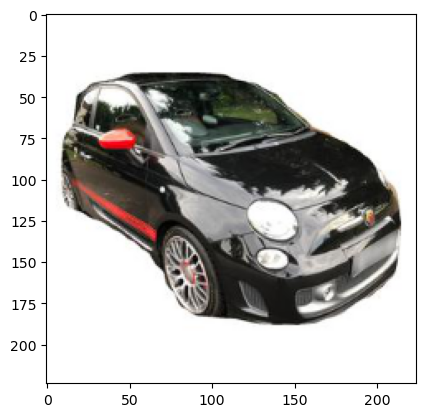

In [5]:
# create image tensors
img_tens, _, _, _, _, _, _ = next(iter(train_set))
img_tens = img_tens.unsqueeze(0)
plotting.imshow(img_tens.detach())

## Saliency Map

In [15]:

# Select model
from models import pretrained_model
model = pretrained_model

# Turn off the gradients since we are using a trained model
for param in model.parameters():
    param.requires_grad = False

# Set the model to evaluation mode
model.eval()

# Saliency map: Calculate gradients of model output wrt input

# Need gradients wrt input image
img_tens.requires_grad = True

# Optional improvement: "Guided backpropagation" (https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/)
# Idea: zero out negative gradients of ReLU layers
def relu_hook_function(module, grad_in, grad_out):
    """Zero out negative gradients for any ReLU units in backward pass."""
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)


for i, module in enumerate(model.modules()):
    """Modify backward pass with ReLU hook."""
    if isinstance(module, torch.nn.ReLU):
        print(model.named_modules())
        module.register_backward_hook(relu_hook_function)

# Forward pass to calculate predictions
preds = model(img_tens)
score, indices = torch.max(preds, 1)

# Backward pass to get gradients of class scores wrt input image
score.backward()

# Compute saliency map
#slc, _ = torch.max(torch.abs(img_tens.grad[0]), dim=0)

slc, _ = torch.max(torch.clamp(img_tens.grad[0], min=0.0), dim=0)
slc = (slc - slc.min()) / (slc.max() - slc.min()) # normaliz

<generator object Module.named_modules at 0x7fb97df4c750>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>
<generator object Module.named_modules at 0x7fb97df4ccd0>


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


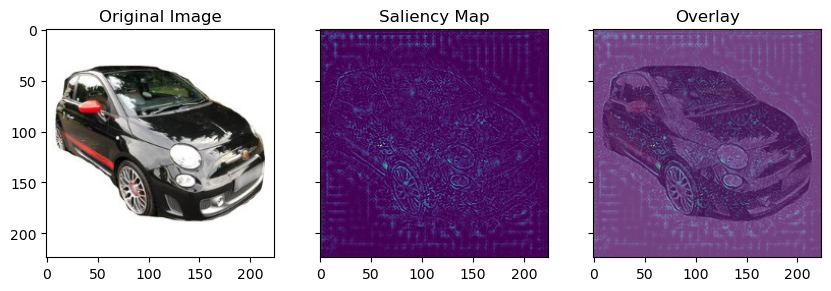

In [16]:
# plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex="row", sharey="row")

input_transformed_for_plot = np.transpose(
    inverse_transform(img_tens)
    .detach()
    .numpy()
    .squeeze(),
    (1, 2, 0),
)

axs[0].imshow(input_transformed_for_plot)
axs[1].imshow(slc, cmap="viridis")
# overly input image with saliency map
axs[2].imshow(input_transformed_for_plot, alpha=0.75)
axs[2].imshow(slc, alpha=0.75)

axs[0].set(title="Original Image")
axs[1].set(title="Saliency Map")
axs[2].set(title="Overlay")
plt.show()